In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

#Webscrapping
!pip install selenium
from selenium import webdriver
from bs4 import BeautifulSoup #Used to parse html text
import requests #Use to retrieve the data from the website

#To load the text file into watson studio notebook
!pip install ibm-cos-sdk
import ibm_boto3
from botocore.client import Config

print("All libraries were loaded")

     |████████████████████████████████| 911kB 7.9MB/s eta 0:00:01
All libraries were loaded


# STAGE ONE

## Web scrapping from "Yellow Pages of Africa-Cameroon"

In [2]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_3 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-72459370-fcff-41f6-94e8-df54fd9e653e',
    'IBM_API_KEY_ID': 'NBIHP-RoTly_vJWfNOlX_7eHHBbiPJra1xZDmom2jq5X',
    'ENDPOINT': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET': 'cameroonproject-donotdelete-pr-ibjpkdutgihuwt',
    'FILE': 'Cameroon.txt'
}
cos = ibm_boto3.client('s3',
                       ibm_api_key_id=credentials_3['IBM_API_KEY_ID'],
                       ibm_service_instance_id=credentials_3['IAM_SERVICE_ID'],
                       ibm_auth_endpoint=credentials_3['IBM_AUTH_ENDPOINT'],
                       config=Config(signature_version='oauth'),
                       endpoint_url=credentials_3['ENDPOINT'])

In [3]:
#Create a function to retrieve a file from Cloud Object Storage
def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_3['BUCKET'], Key=filename)['Body']
    return fileobject

#Load Text file into a Python string
def load_string(fileobject):
    '''Load the file contents into a Python string'''
    text = fileobject.read()
    return text

In [4]:
cm_obj=get_file('Cameroon.txt') #Retrieving file from cloud
file_str=load_string(cm_obj) #Loading the text file into program
cm_vec=file_str.decode().split("\r\n") #Split the file at points having special character \r\n
print("Total number of items: ",len(cm_vec))

Total number of items:  472


In [5]:
#website's url
url="https://www.yellowpagesofafrica.com/country/cameroon/"
url_source = requests.get(url)
html_soup = BeautifulSoup(url_source.content, 'html.parser') #Parsing the url into an html
#html_soup.h1 #Header of page
#html_soup.body #prints the body of the html

In [6]:
#Grabs each business main category
html_soup_categ=html_soup.findAll('div',{"class":"col-sm-12 ct-u-marginTop20 ct-u-marginBottom10"})
#Grabs activities under each category
html_soup_act=html_soup.findAll('h3',{"class":"activites"})


In [7]:
print("Number of categories: ",len(html_soup_categ))
print("Number of activities: ",len(html_soup_act))

Number of categories:  23
Number of activities:  449


## Creating dataframe based on the "sector" and "activity"

In [15]:
#Retrieving the indeces of categories from text having both categories and activities
cat_index=[]
for cat in range(0,len(html_soup_categ)):
    for cat_act in range(0,len(cm_vec)):
        if html_soup_categ[cat].b.text.strip().replace("\n"," ")==cm_vec[cat_act].replace("\n"," "):
            cat_index.extend([cm_vec.index(html_soup_categ[cat].b.text.strip().replace("\n"," "))])
cat_index=sorted(list(set(cat_index)))
print("Indeces of categories in text: ",cat_index) 

#Creating a vector of activities
act_vec=[]
for i in range(0,len(html_soup_act)):
    act_vec.append(html_soup_act[i].text.strip().replace("\n"," "))

#Creating a vector of categories
cat_vec=[]
for i in range(0,len(html_soup_categ)):
    cat_vec.append(html_soup_categ[i].b.text.strip().replace("\n"," "))

Indeces of categories in text:  [0, 10, 22, 39, 53, 133, 152, 162, 195, 203, 223, 232, 257, 265, 304, 320, 331, 366, 372, 385, 392, 402, 438]


In [16]:
#Grouping the activities from the text into categories
grouped_act=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(0,len(cat_vec)):
    first=cat_index[i]+1
    last=cat_index[i+1]
    print(i," ",cat_vec[i])
    print("------------------------------------ ")
    print(cm_vec[first:last])
    grouped_act[i].extend(cm_vec[first:last])
    if last>len(cat_vec)-1:
        grouped_act[i].extend(cm_vec[first:len(cat_vec)])
    print(" ")

0   ADMINISTRATIONS, EMBASSIES, MINISTERS, STATE ORGANIZATIONS
------------------------------------ 
['ADMINISTRATIONS', 'ASSOCIATIONS', 'CUSTOMS, AGENCY', 'EMBASSIES ET CONSULATES', 'MINISTRIES', 'NATIONAL SERVICES', 'O.N.G ET INTERNATIONAL ORGANIZATION', 'POST OFFICE', 'SOCIAL SECURITY']
 
1   AGRICULTURE
------------------------------------ 
['AGRICULTURAL, CHEMICALS', 'AGRICULTURAL, EQUIPMENTS ET PRODUCT', 'AGRICULTURAL, INDUSTRIES', 'AGRICULTURE', 'AGRICULTURE, EQUIPMENT ET MATERIALS', 'AGRICULTURE, PRODUCTS', 'AGRO-INDUSTRY', 'ANIMAL HUSBANDRY', 'ANIMAL HUSBANDRY, TRAINING CENTER', 'BREEDING, CONSULTANTS', 'FOOD-PROCESSING INDUSTRY']
 
2   AUTOMOBILE, MOTORCYCLE, DEALERS, SPARE PARTS
------------------------------------ 
['CARS ET DEALERS', 'CARS OF OCCASIONS', 'CARS, EXPERTISES', 'CARS, REPLACEMENT ET SECONDARY PIEC...', 'CYCLES ET MOTORBIKES', 'DRIVING SCHOOLS', 'GARAGES', 'GENERAL MECHANICS', 'INDUSTRIAL VEHICULES', 'MACHINES OF CONSTRUCTION ET MATERIA...', 'MECHANICAL CONSTRU

IndexError: list index out of range

The last empty list couldn't be appended. This problem seemed wierd!

In [17]:
#Manually adding the last grouped activities
grouped_act[-1].extend(cm_vec[439:])

In [18]:
print("Number of groups having activities: ",len(grouped_act))
print("Number of categories: ",len(cat_vec))

Number of groups having activities:  23
Number of categories:  23


In [19]:
#Creating a vector of categories repeated using the number of each grouped activities
cat_col=[]
for i in range(0,len(grouped_act)):
    cat_col=cat_col+[cat_vec[i]]*len(grouped_act[i])
print("Number of activities: ",len(cat_col))

Number of activities:  449


In [20]:
#Creating the dataframe
df=pd.DataFrame({"Sector":cat_col,"Activity":act_vec})
df.head()

,Sector,Activity
0,"ADMINISTRATIONS, EMBASSIES, MINISTERS, STATE O...",ADMINISTRATIONS
1,"ADMINISTRATIONS, EMBASSIES, MINISTERS, STATE O...",ASSOCIATIONS
2,"ADMINISTRATIONS, EMBASSIES, MINISTERS, STATE O...","CUSTOMS, AGENCY"
3,"ADMINISTRATIONS, EMBASSIES, MINISTERS, STATE O...",EMBASSIES ET CONSULATES
4,"ADMINISTRATIONS, EMBASSIES, MINISTERS, STATE O...",MINISTRIES


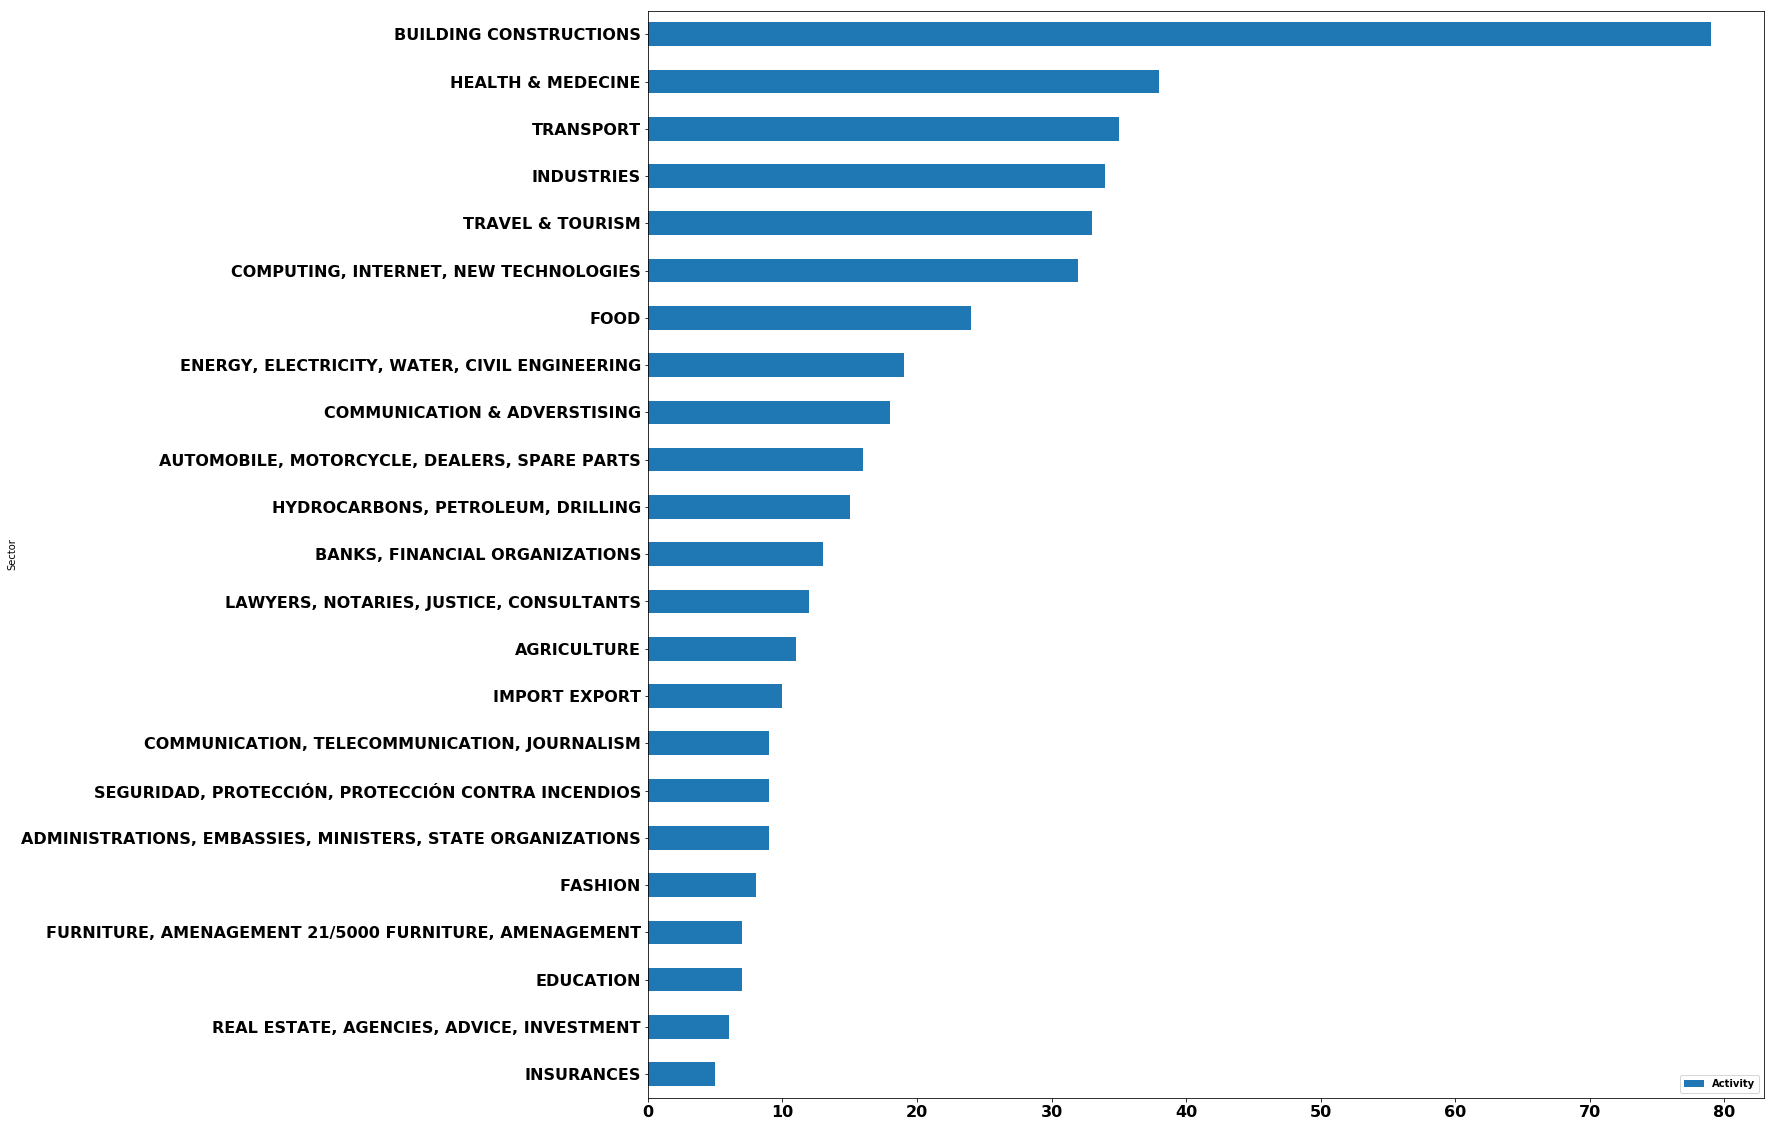

In [91]:
df_hist=df.groupby("Sector").count().sort_values("Activity",ascending=True)
df_hist.plot(kind="barh",figsize=(20, 20),fontsize=16)

In [23]:
clust_dum=pd.get_dummies(df[['Sector']], prefix="", prefix_sep="")
clust_dum["Activity"]=df["Activity"]
clust_dum=clust_dum[[clust_dum.columns[-1]] + list(clust_dum.columns[:-2])]
#clust_dum.head(10)

# STAGE TWO

## Web scrapping the activities in the "Building constructions" sector

In [24]:
df_BC=df[df["Sector"]=="BUILDING CONSTRUCTIONS"].reset_index()
df_BC=df_BC[["Sector","Activity"]]
df_BC.head()

,Sector,Activity
0,BUILDING CONSTRUCTIONS,"AIR CONDITIONING, TROUBLESHOOTING E..."
1,BUILDING CONSTRUCTIONS,AIR-CONDITIONING
2,BUILDING CONSTRUCTIONS,ALUMINIUM JOINERY
3,BUILDING CONSTRUCTIONS,"ALUMINIUM, INDUSTRIES"
4,BUILDING CONSTRUCTIONS,"ARCHITECTURE ET TOWN PLANNING, CABI..."


In [157]:
print("Number of activities: ",len(df_BC["Activity"]))

Number of activities:  79


In [25]:
#Preprocessing the activity endpoints
act_link=[]
for i in range(0,len(df_BC)):
    act_link.append(df_BC.iloc[i,1].lower().replace(", ","-").replace(" ","-"))
    if act_link[i]=='air-conditioning-troubleshooting-e...':
        act_link[i]='air-conditioning-troubleshooting-maintenance'
    if act_link[i]=='architecture-et-town-planning-cabi...':
        act_link[i]='architecture-et-town-planning-cabinets'
    if act_link[i]=='buildings-second-works-of-the-buil...':
        act_link[i]='buildings-second-works-of-the-building'
    if act_link[i]=='careers-exploitations-et-explorati...':
        act_link[i]='careers-exploitations-et-explorations'
    if act_link[i]=='engineering-consulting-firms-et-des...':
        act_link[i]='engineering-consulting-firms-design-departments'
    if act_link[i]=='forestry-workers-materials-et-equi...':
        act_link[i]='forestry-workers-materials-equipment'
    if act_link[i]=='laboratories-of-analyses-of-the-bui...':
        act_link[i]='laboratories-of-analyses-of-the-building-tp'
for i in range(0,len(act_link)):
    act_link[i]=act_link[i].replace("-et-","-")
print(act_link)

['air-conditioning-troubleshooting-maintenance', 'air-conditioning', 'aluminium-joinery', 'aluminium-industries', 'architecture-town-planning-cabinets', 'asphalt-manufacturing', 'boilermaking-industry', 'brickyards', 'building-materials', 'building-prefabricated', 'building-valued', 'buildings-public-works', 'buildings-cleaning', 'buildings-rehabilitation', 'buildings-second-works-of-the-building', 'cables-industries', 'careers-exploitations-explorations', 'cement-factories', 'civil-engineering', 'cleansing-lines', 'concrete-manufacture', 'doors-windows', 'drillings', 'drillings-maintenance', 'drillings-materials-equipment', 'ebenistes', 'elevators', 'engineering-consulting-firms-design-departments', 'forestry-workers-materials-equipment', 'geologists', 'green-spaces-gardens', 'handiwork', 'hardware', 'house-painters-public-works', 'hydraulic-materials-equipment', 'hydraulics', 'hydraulics-constructions', 'industrial-constructions', 'industrial-joinery', 'iron-steel-industries', 'iron-

In [26]:
#Retrieving the urls for each endpoint
url_vec=[]
for i in range(0,len(act_link)):
    url_BC="https://www.yellowpagesofafrica.com/companies/cameroon/{}/".format(act_link[i])
    url_vec.append(url_BC)
url_vec[0:3]

['https://www.yellowpagesofafrica.com/companies/cameroon/air-conditioning-troubleshooting-maintenance/',
 'https://www.yellowpagesofafrica.com/companies/cameroon/air-conditioning/',
 'https://www.yellowpagesofafrica.com/companies/cameroon/aluminium-joinery/']

In [27]:
#Function to extract the city
def preproc(raw_location):
    for i in range(0,len(raw_location)):
        if raw_location[i]=='See':
            start=raw_location.index(raw_location[i])
    del raw_location[start:]
    for j in range(0,len(raw_location)):
        if raw_location[j]=='-':
            end=raw_location.index(raw_location[j])
    del raw_location[0:end+1]
    return raw_location[0]

Adding the companies and location from the first page

In [28]:
locations=[]
companies=[]
for i in range(0,len(url_vec)):
    #website's url
    url_source = requests.get(url_vec[i])
    html_soup = BeautifulSoup(url_source.content, 'html.parser') #Parsing the url into an html
    #Grabs each company
    html_soup_comp=html_soup.findAll('div',{"class":"ct-product--tilte"})
    comp_loc=[]
    for comp in range(0,len(html_soup_comp)):
        comp_loc.append(html_soup_comp[comp].text.strip())
    companies.append(comp_loc)
    #Grabs each location
    html_soup_loc=html_soup.findAll('div',{"class":"ct-product--description"})
    loc_comp=[]
    for loc in range(0,len(html_soup_loc)):
        loc_comp.append(preproc(html_soup_loc[loc].text.split()))
    locations.append(loc_comp)

Extracting more companies and location of the next pages of the same activity

In [29]:
for i in range(0,len(url_vec)):
    url_base=url_vec[i] #Base url
    for nx in range(1,3):
        url_next=url_base+"start-{}1/".format(nx) #Getting the next page of the activity url
        url_source = requests.get(url_next)
        html_soup = BeautifulSoup(url_source.content, 'html.parser') #Parsing the url into an html
        #Grabs each company
        html_soup_comp=html_soup.findAll('div',{"class":"ct-product--tilte"})
        #Grabs each location
        html_soup_loc=html_soup.findAll('div',{"class":"ct-product--description"})
        for act in range(0,len(url_vec)):
            for comp in range(0,len(html_soup_comp)):
                companies[act].append(html_soup_comp[comp].text.strip())
            for loc in range(0,len(html_soup_loc)):
                locations[act].append(preproc(html_soup_loc[loc].text.split()))
        

In [31]:
activity=[]
Locations=[]
Companies=[]
for act in range(0,len(act_link)):
    activity=activity+[act_link[act]]*len(companies[act])
for loc in range(0,len(locations)):
    Locations.extend(locations[loc])
for comp in range(0,len(companies)):
    Companies.extend(companies[comp])
print("First 5 activities: ",list(set(activity))[0:5])
print("Number of appearances of companies: ",len(Companies))
print("Number of appearances of locations: ",len(Locations))

First 5 activities:  ['cleansing-lines', 'management-of-urban-land', 'laboratories-of-analyses-of-the-building-tp', 'water-conveyance-vrd', 'drillings-materials-equipment']
Number of appearances of companies:  12498
Number of appearances of locations:  12498


# Exploratory analysis

In [32]:
#Creating dataframe of information from webscrapping of the "Building and construction" pages
df_BC_Act=pd.DataFrame({"Activity":activity,"Locations":Locations,"Companies":Companies})
df_BC_Act.head()

,Activity,Locations,Companies
0,air-conditioning-troubleshooting-maintenance,DOUALA,FREEMEN COMPANY
1,air-conditioning-troubleshooting-maintenance,DOUALA,JEPSE DEPANNAGE
2,air-conditioning-troubleshooting-maintenance,DOUALA,KENSON MOTOR
3,air-conditioning-troubleshooting-maintenance,DOUALA,SOCIETE AFES
4,air-conditioning-troubleshooting-maintenance,DOUALA,EASY LIFE


In [33]:
#Removing location not found in Cameroon
df_BC_proc1=df_BC_Act.loc[df_BC_Act["Locations"]!='ISTANBUL/TURQUIE',]
df_BC_proc2=df_BC_proc1.loc[df_BC_proc1["Locations"]!='75784',]
df_BC_proc3=df_BC_proc2.loc[df_BC_proc2["Locations"]!='ISTANBUL/TURQUIE',]
df_BC_proc3.head()

,Activity,Locations,Companies
0,air-conditioning-troubleshooting-maintenance,DOUALA,FREEMEN COMPANY
1,air-conditioning-troubleshooting-maintenance,DOUALA,JEPSE DEPANNAGE
2,air-conditioning-troubleshooting-maintenance,DOUALA,KENSON MOTOR
3,air-conditioning-troubleshooting-maintenance,DOUALA,SOCIETE AFES
4,air-conditioning-troubleshooting-maintenance,DOUALA,EASY LIFE


## Exploring the number of companies per activity

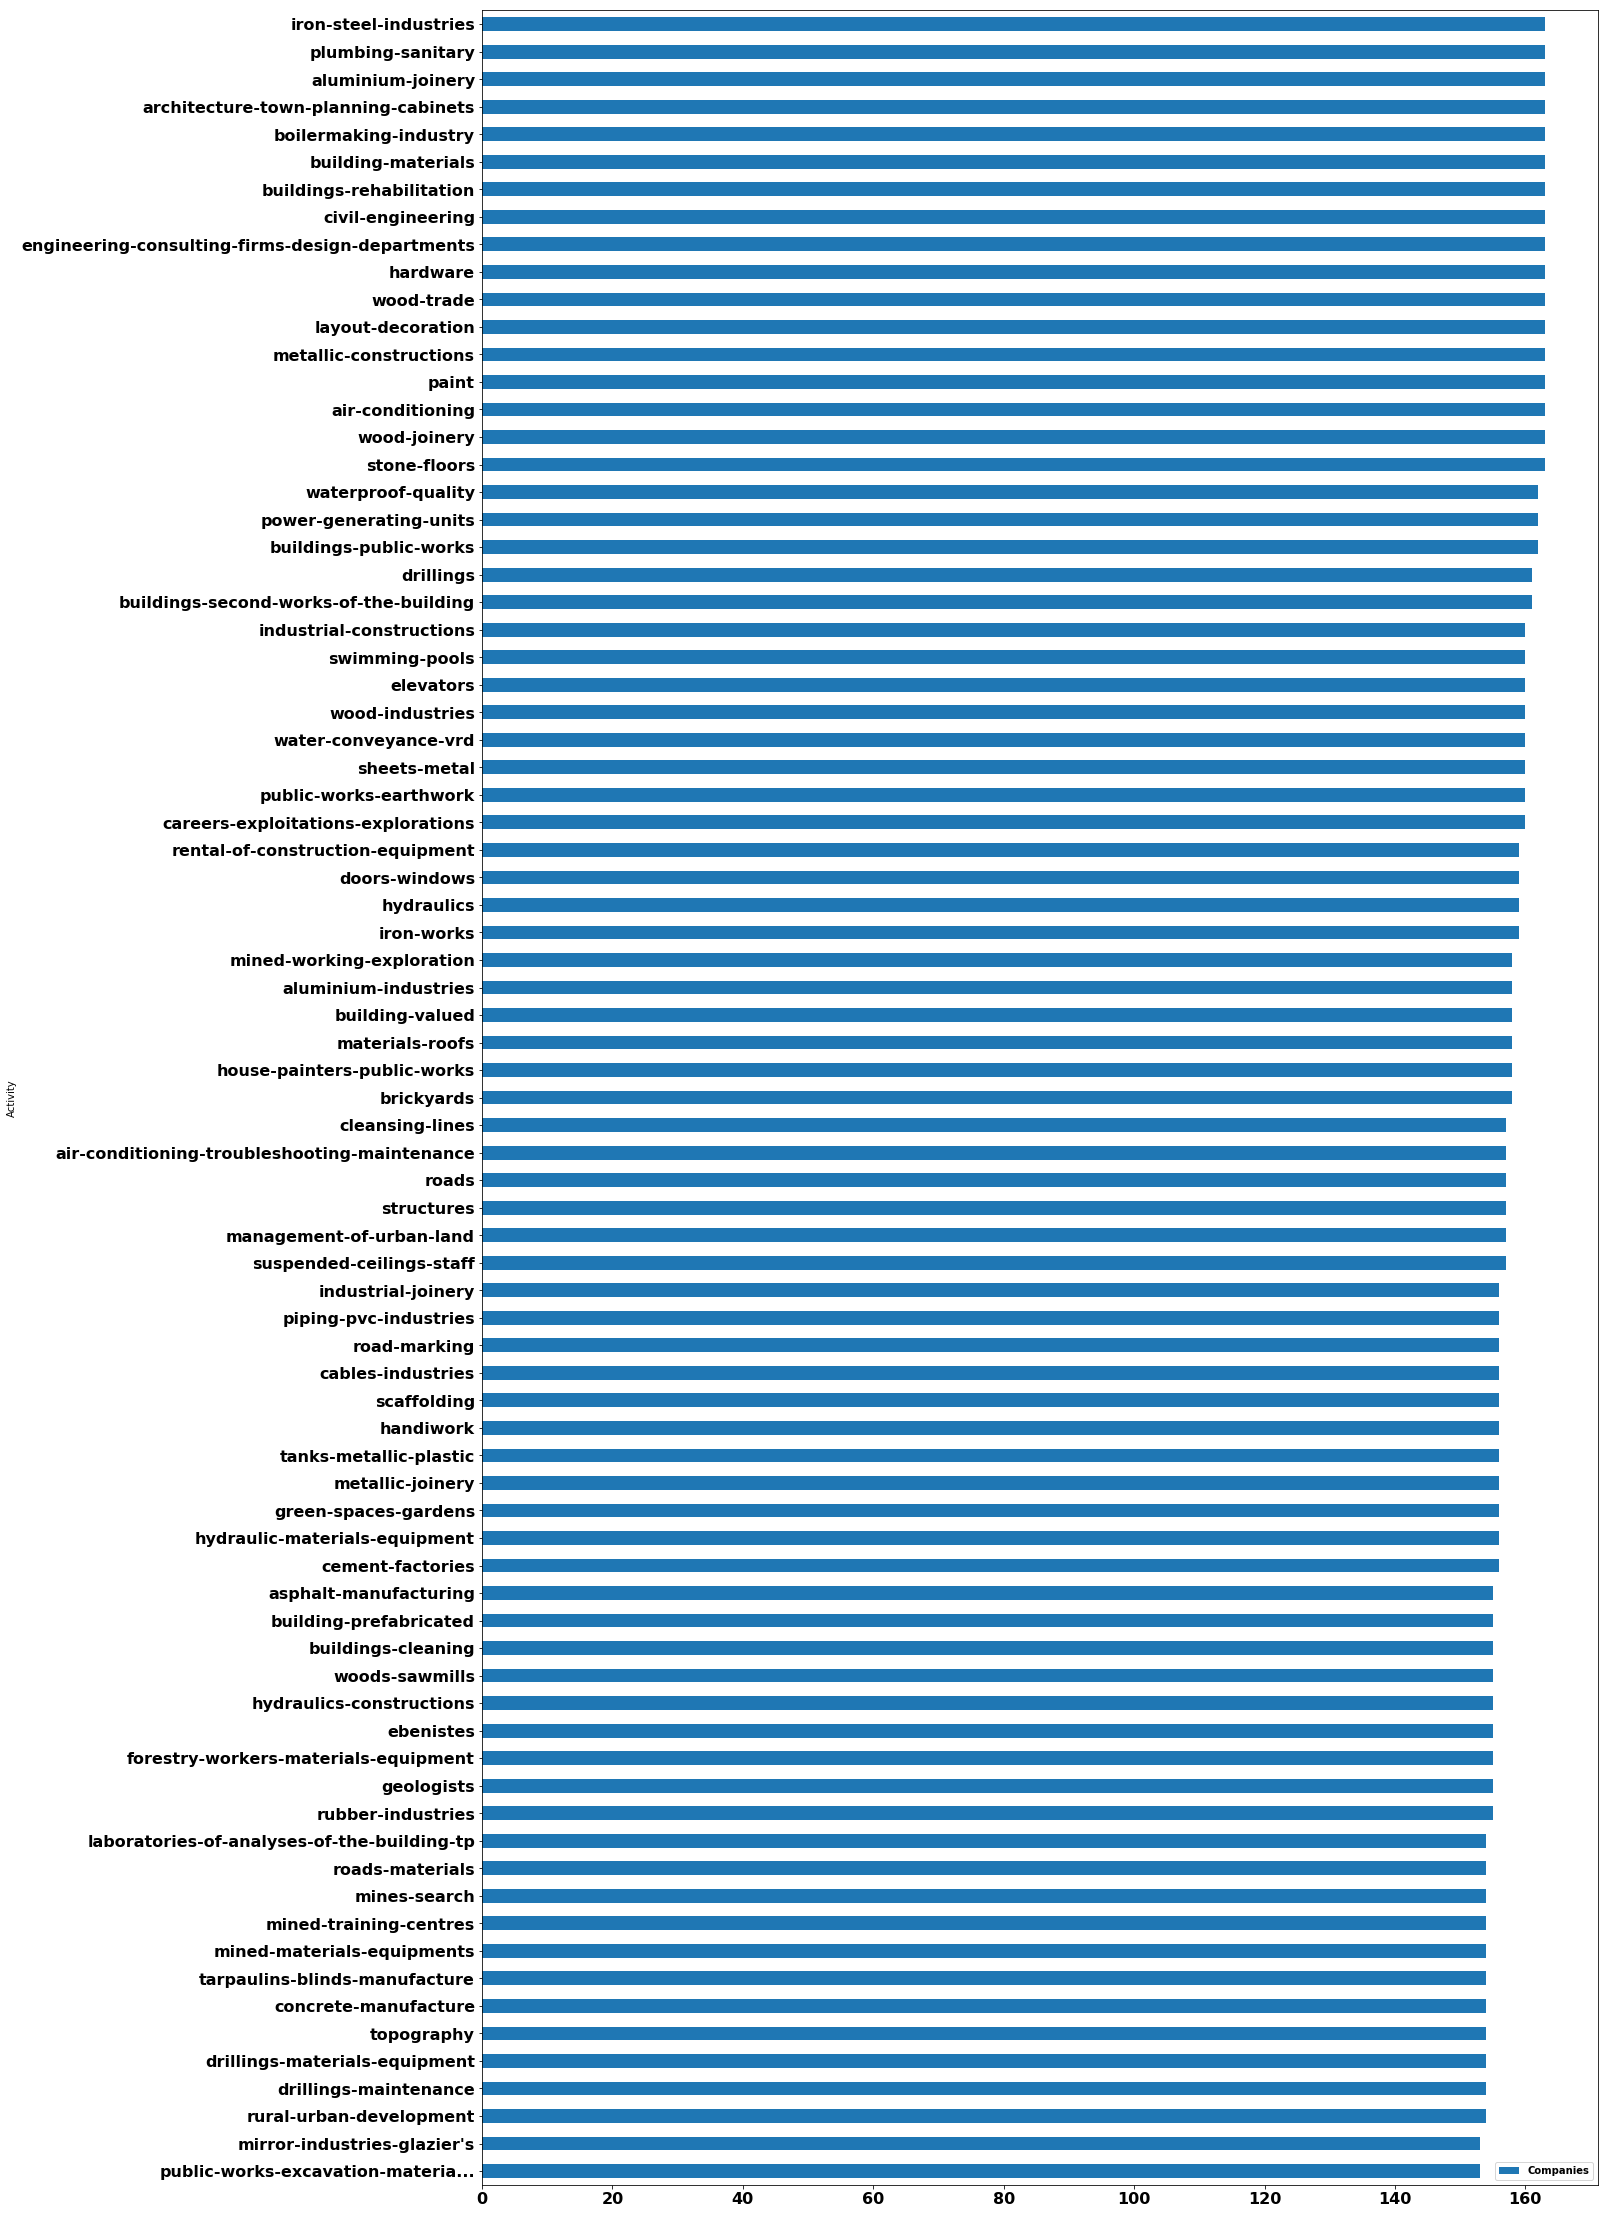

In [92]:
df_ActComp=df_BC_proc3[["Activity","Companies"]].groupby("Activity").count().sort_values("Companies",ascending=True)
df_ActComp.plot(kind="barh",figsize=(20, 40),fontsize=16)

## Exploring the number of companies per location

First, a heatmap was used to visualize activities vs location with the number of companies as the quantitative measurement

In [72]:
df_ActLoc=df_BC_proc3.groupby(["Activity","Locations"]).size().reset_index().rename(columns={0:'Company count'})
df_ActLoc_piv=df_ActLoc.pivot(index="Activity",columns="Locations",values="Company count")
loc_name=["BAFOUSSAM","BAMENDA","BANGANGTE","BERTOUA","BUEA","DOUALA","EDEA","GAROUA","KOUSSERI","KUMBA","LIMBE","MBALMAYO","N'GAOUNDERE","NGAOUNDERE","YAOUNDE"]
for loc in loc_name:
    df_ActLoc_piv[loc]=df_ActLoc_piv[loc].fillna(0)
df_ActLoc_piv.head()




Locations,BAFOUSSAM,BAMENDA,BANGANGTE,BERTOUA,BUEA,DOUALA,EDEA,GAROUA,KOUSSERI,KUMBA,LIMBE,MBALMAYO,N'GAOUNDERE,NGAOUNDERE,YAOUNDE
Activity,,,,,,,,,,,,,,,
air-conditioning,1.0,0.0,0.0,0.0,0.0,102.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,57.0
air-conditioning-troubleshooting-maintenance,1.0,0.0,0.0,0.0,0.0,99.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,54.0
aluminium-industries,1.0,0.0,0.0,0.0,0.0,99.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,54.0
aluminium-joinery,1.0,0.0,0.0,0.0,0.0,103.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,55.0
architecture-town-planning-cabinets,1.0,0.0,0.0,0.0,0.0,99.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,60.0


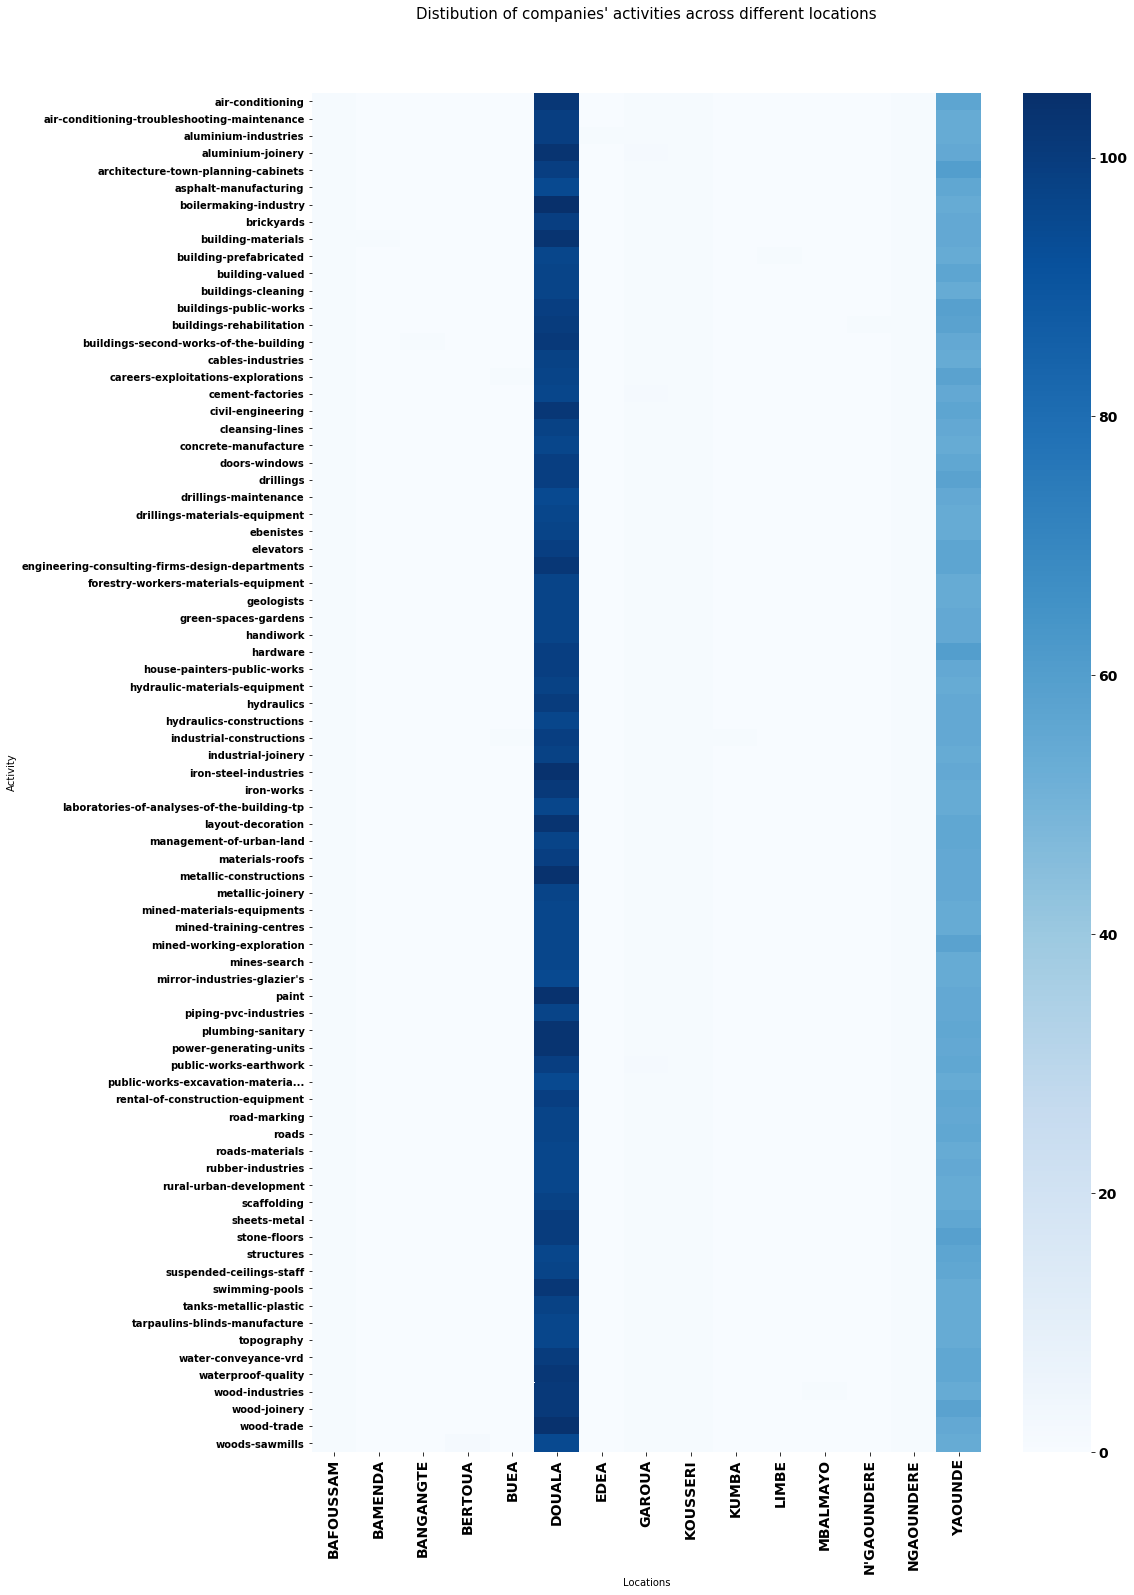

In [87]:
fig, ax = plt.subplots(figsize=(15,25))
title="Distibution of companies' activities across different locations"
plt.title(title,fontsize=15)
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
ttl=ax.title
ttl.set_position([0.5,1.05])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('on')

sns.heatmap(df_ActLoc_piv,ax=ax,cmap="Blues")
plt.show()

In [309]:
print("Number of unique companies in Cameroon: ",len(list(set(df_BC_proc3["Companies"]))))

Number of unique companies in Cameroon:  392


A company can have multiple activities! Therefore, to obtain the number of companies per location, the dataframe without the "activity" column

In [35]:
df_Comp_loc=df_BC_proc3[["Companies","Locations"]].drop_duplicates()
df_Comp_loc=df_Comp_loc[["Companies","Locations"]].groupby("Locations").count().sort_values("Companies",ascending=False)
#df_Comp_loc.plot(kind="barh",figsize=(20, 15),fontsize=14)
df_Comp_loc


,Companies
Locations,
DOUALA,274
YAOUNDE,119
GAROUA,4
BERTOUA,2
BUEA,2
BAFOUSSAM,1
BAMENDA,1
BANGANGTE,1
EDEA,1


## Exploring the number of activities per company and location

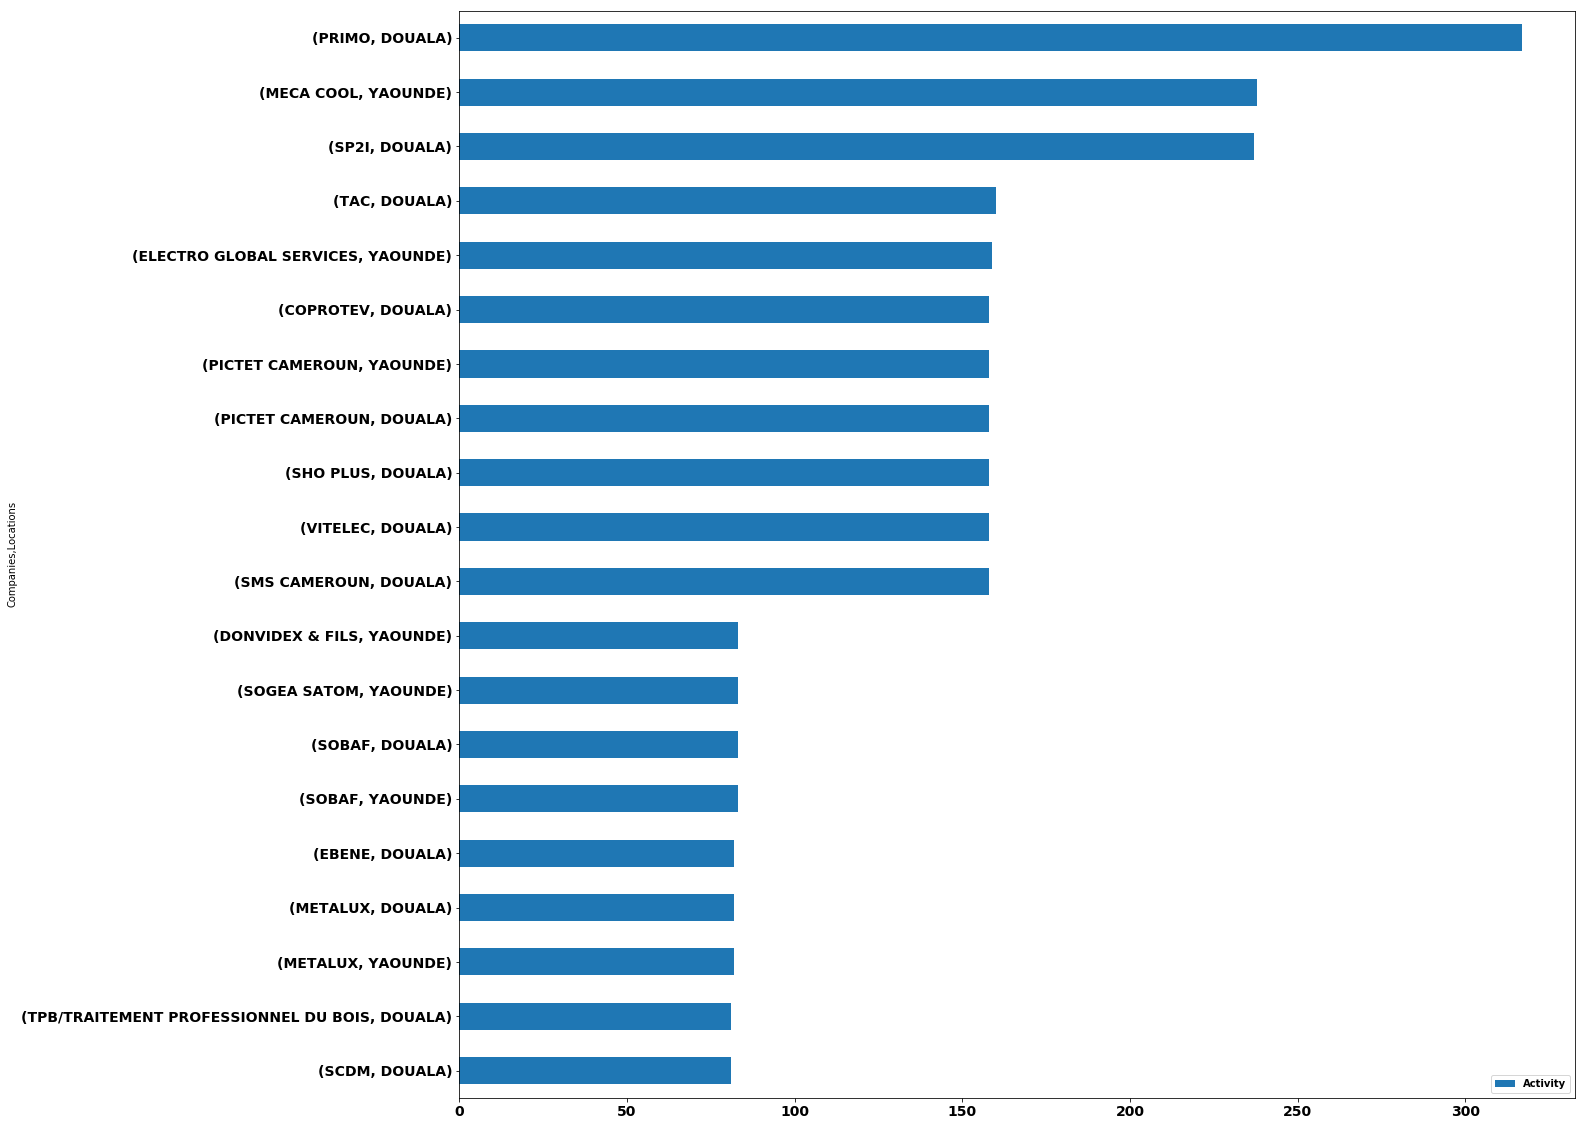

In [113]:
df_ComLocAct=df_BC_proc3.groupby(["Companies","Locations"]).count()
df_ComLocAct=df_ComLocAct.sort_values("Activity",ascending=True)
df_ComLocAct[-20:].plot(kind="barh",figsize=(20, 20),fontsize=14) #displaying the top 20 most active companies